In [128]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.ion()

def _unpackstr(s):
    return s[1:-1]


def _unpackset(s, lines):
    s = s.strip()
    while lines and not s.endswith('}'):
        s += " " + lines.pop(0).strip()
    vv = []
    s = s[1:-1].strip()
    while s:
        if s.startswith("'"):
            idx = s[1:].index("'")
            vv.append(s[1:idx+1])
            s = s[idx+2:].strip()
        elif ' ' in s:
            idx = s.index(" ")
            v = s[:idx]
            if "." in v:
                vv.append(float(v))
            else:
                vv.append(int(v))
            s = s[idx+1:].strip()
    return vv


def loadescope(fn):
    '''Load a recording from EScope
    Arguments:
        fn - Filename to load. This may be the “.txt” or the “.dat” file
    Returns:
        data - Data as a numpy array
        info - Auxiliary information

    Data is shaped as CxNxL, where:
        C is the number of channels in the recording
        N is the number of sweeps
        L is the length of each sweep
    
    Info is a dictionary with the following contents:
        "rundate" - the YYYYMMDD-HHMMSS formatted time when data were acquired
        "rate_hz" - the sampling rate (in Hertz)
        "channels" - the names of the input channels
        "scale" - the physical meaning of a value of 1.0 in each channel
    '''

    if fn.endswith(".txt") or fn.endswith(".dat"):
        fn = fn[:-4]
    info = {}
    with open(fn + ".txt", "r") as fd:
        lines = fd.readlines()
        while lines:
            line = lines.pop(0)
            if " = " in line:
                k, v = line.split(" = ")
                v = v.strip()
                print(f"key=[{k}] value=[{v}]")
                if v.startswith("{"):
                    v = _unpackset(v, lines)
                elif v.startswith("'"):
                    v = _unpackstr(v)
                elif "." in v:
                    v = float(v)
                else:
                    v = int(v)
                info[k] = v

    with open(fn + ".dat", "rb") as fd:
        data = fd.read()
    print(info)
    data = np.frombuffer(data)
    C = len(info['channels'])
    S = info['scans_per_sweep']
    N = len(data) // S // C
    
    data = data[:N*S*C].reshape(N, S, C).transpose([2,0,1])
    return data, info


def plotescope(data, info):
    '''Example of how to plot data from EScope
    Arguments:
        data - must be a CxNxL array from loadescope()
        info - must be an auxiliary information dictionary from loadescope()
    Returns:
        -
    Plots all the channels in a single figure; sweeps are concatenated
    together.
    '''
    C, N, S = data.shape
    tt = np.arange(N*S) / info['rate_hz']
    plt.plot(tt, data[1].reshape(N*S).T)
    plt.plot(tt, data[0].reshape(N*S).T)
    plt.xlabel('Time (s)')
    cs = [f"{c} ({s})" for c,s in zip(info['channels'], info['scale'])]
    plt.ylabel("; ".join(cs))
    plt.title(info['rundate'])


## load data as described above:
#data, info = loadescope("file_name.dat")
#plotescope(data, info)


key=[rundate] value=['20231023-160516']
key=[rate_hz] value=[10000]
key=[channels] value=[{ 'ai0' 'ai1' }]
key=[nchannels] value=[2]
key=[scale] value=[{ '1 V']
key=[scans_per_sweep] value=[10000]
key=[sweepperiod_s] value=[1]
{'rundate': '20231023-160516', 'rate_hz': 10000, 'channels': ['ai0', 'ai1'], 'nchannels': 2, 'scale': ['1 V', '1 V'], 'scans_per_sweep': 10000, 'sweepperiod_s': 1}


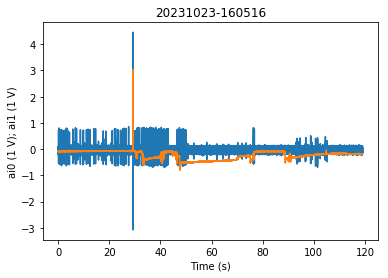

In [129]:
data, info = loadescope('160516.dat')
plotescope(data, info)

In [134]:
def plot_region(data, info, t_on, t_off):
#     t_window = t_spike - 0.005
#     tw_s = int((t_window % 1) * 10000)
    data_trunc = data[:,t_on:t_off,:] * 100
#     if np.max(data_trunc) < thresh and np.min(data_trunc) > -thresh: return
    
    C, N, S = data_trunc.shape
    tt = np.arange(N*S) / info['rate_hz']
    plt.plot(tt, data_trunc[1].reshape(N*S).T)
    plt.plot(tt, data_trunc[0].reshape(N*S).T)
    plt.ylim(-80, 100)
    plt.xlabel('Time (s)')
    plt.legend(['Extracellular', 'Intracellular'])
    plt.ylabel("Voltage (mV)")
    plt.title(f"{info['rundate']} t=[{t_on}s, {t_off}s]")
#     if savefig: plt.savefig(f'spikes/t_{round(t_window, 3)}s_{round(t_window + window_size/10000, 3)}s.png')
    plt.show()

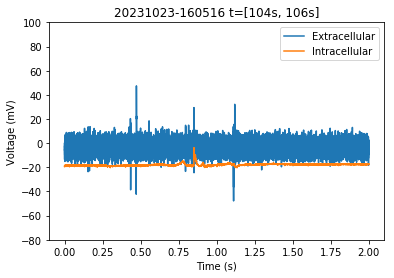

In [151]:
plot_region(data, info, 104, 106)

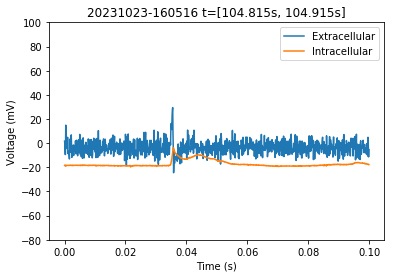

In [166]:
plot_spike(data, info, 104.82, 1000, thresh=5)
# plot_spike(data, info, 42.15, thresh=5)
# plot_spike(data, info, 42.2, thresh=5)
# plot_spike(data, info, 42.25, thresh=5)

In [138]:
def plot_spike(data, info, t_spike, window_size=500, thresh=25, savefig=False):
    t_window = t_spike - 0.005
    tw_s = int((t_window % 1) * 10000)
    data_trunc = data[:,int(np.floor(t_window)):int(np.floor(t_window))+1,tw_s:tw_s + window_size] * 100
    if np.max(data_trunc) < thresh and np.min(data_trunc) > -thresh: return
    
    C, N, S = data_trunc.shape
    tt = np.arange(N*S) / info['rate_hz']
    plt.plot(tt, data_trunc[1].reshape(N*S).T)
    plt.plot(tt, data_trunc[0].reshape(N*S).T)
    plt.ylim(-80, 100)
    plt.xlabel('Time (s)')
    plt.legend(['Extracellular', 'Intracellular'])
    plt.ylabel("Voltage (mV)")
    plt.title(f"{info['rundate']} t=[{round(t_window, 3)}s, {round(t_window + window_size/10000, 3)}s]")
    if savefig: plt.savefig(f'spikes/t_{round(t_window, 3)}s_{round(t_window + window_size/10000, 3)}s.png')
    plt.show()

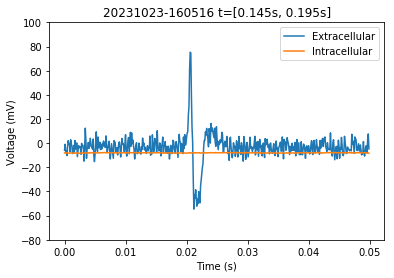

In [139]:
plot_spike(data, info, 0.15)

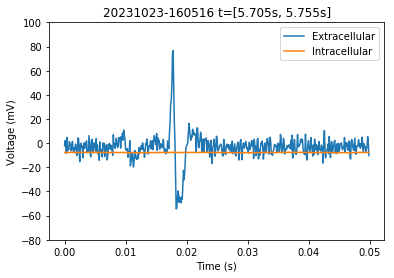

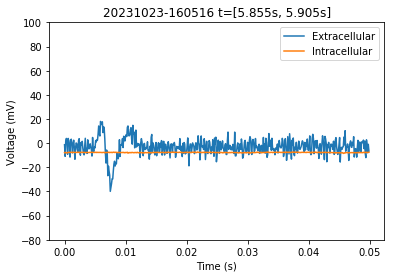

In [140]:
plot_spike(data, info, 5.71)
plot_spike(data, info, 5.86)

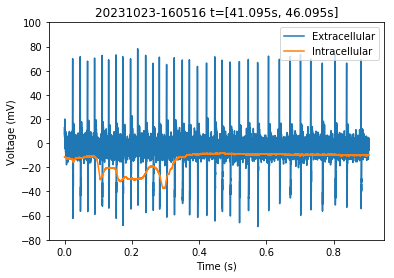

In [130]:
plot_spike(data, info, 41.1, 50000)

In [125]:
def plot_all_spikes(data, info, t_start, t_end):
    for t in np.arange(t_start, t_end, 0.05):
        plot_spike(data, info, t, savefig=True)

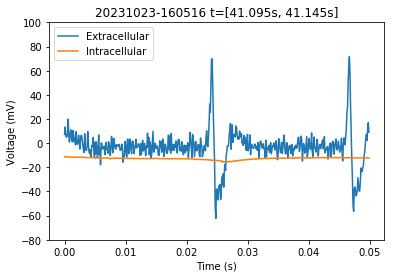

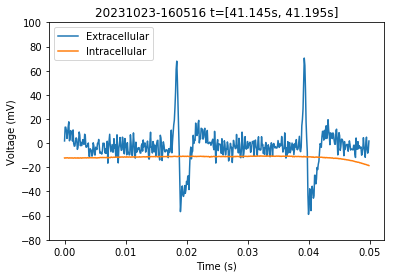

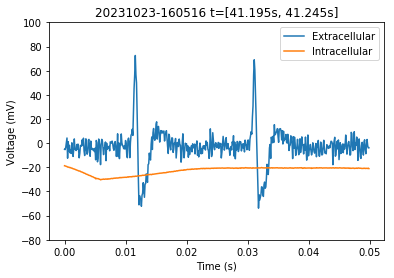

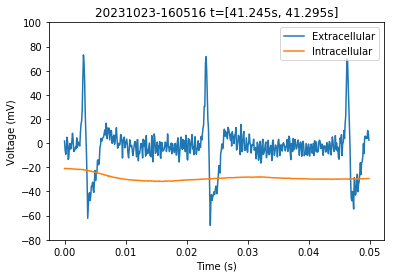

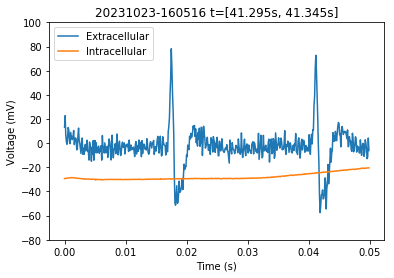

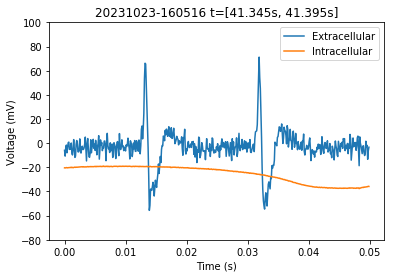

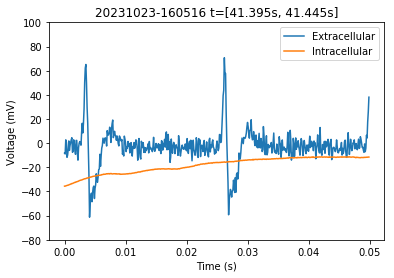

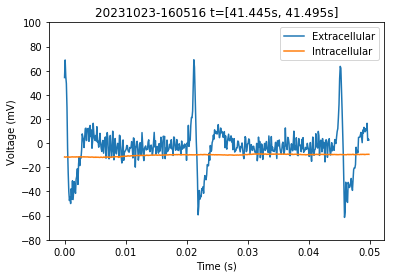

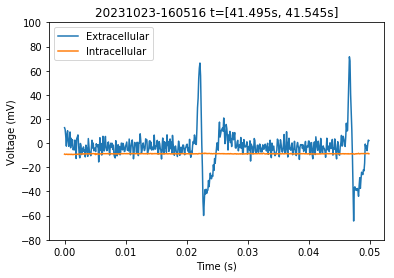

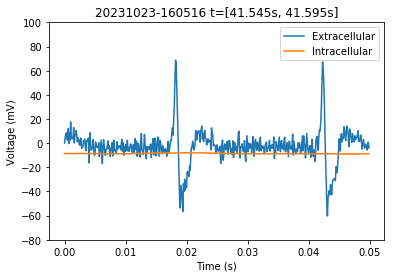

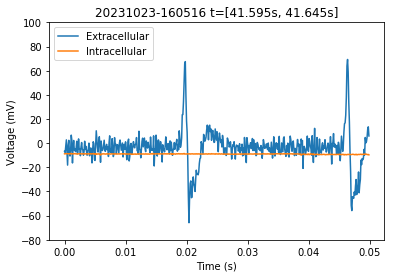

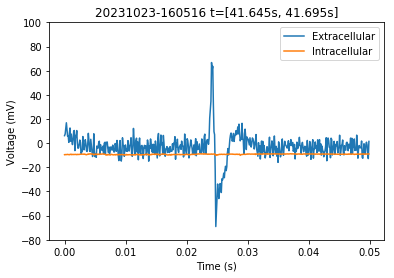

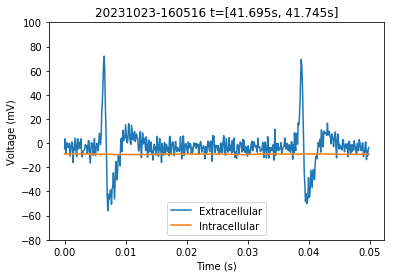

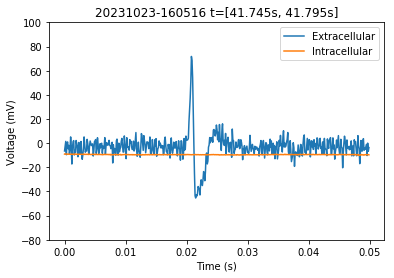

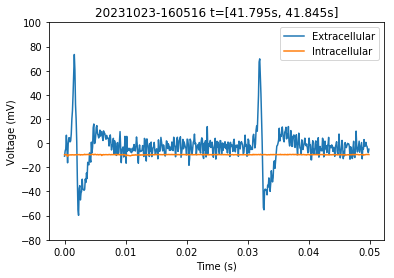

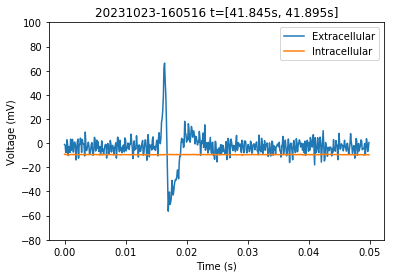

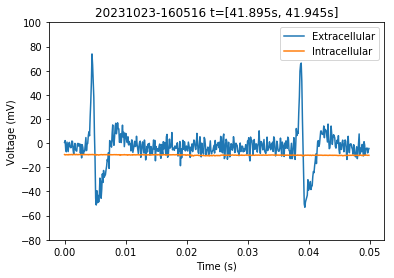

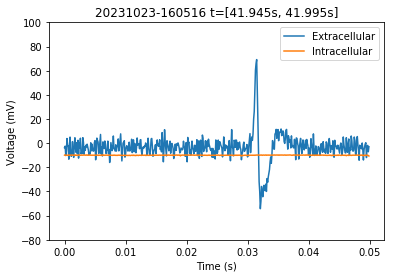

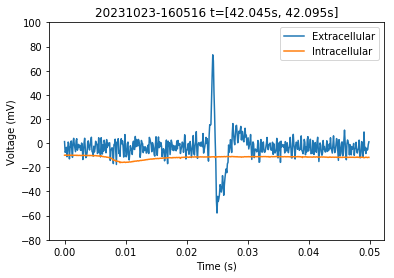

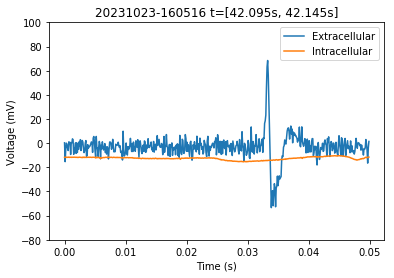

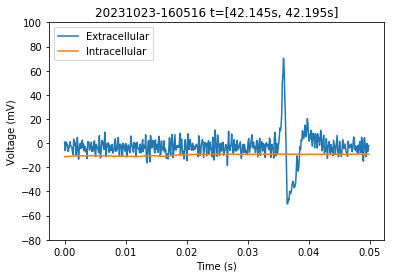

In [131]:
plot_all_spikes(data, info, 41.1, 42.2)

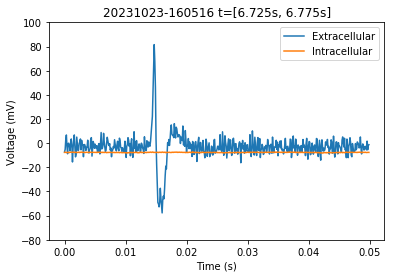

In [120]:
plot_spike(data, info, 6.73)